# Code modified from Keras:
### Next-Frame Video Prediction with Convolutional LSTMs

https://keras.io/examples/vision/conv_lstm/

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

import cv2

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print('libs loaded .........')

libs loaded .........


In [6]:
# Download and load the dataset.

fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

print(type(dataset))
dataset.shape

 23699456/819200096 ━━━━━━━━━━━━━━━━━━━━ 5:52:15 27us/step

KeyboardInterrupt: 

### 1k samples or videos. 
### Each video has 20 frames. 
### Each frame H=64 X W=64 X 1 channel (grayscale)

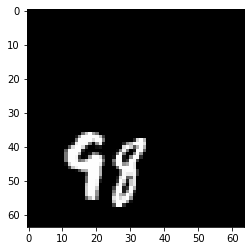

In [ ]:
# Display one frame

v = 123 
f = 11

plt.imshow(np.squeeze(dataset[v][f]), cmap="gray")

Displaying frames for example 123.


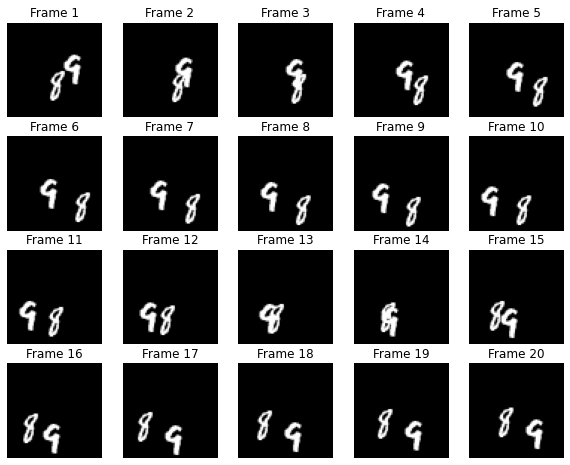

In [ ]:
# All frames of ONE video

v = 123 

# Construct a figure on which we will visualize all the frames of one video.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(dataset[v][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {v}.")
plt.show()


In [ ]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

print('train ' , train_dataset.shape)
print('val ' , val_dataset.shape)

train  (900, 20, 64, 64, 1)
val  (100, 20, 64, 64, 1)


In [ ]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for example 504.


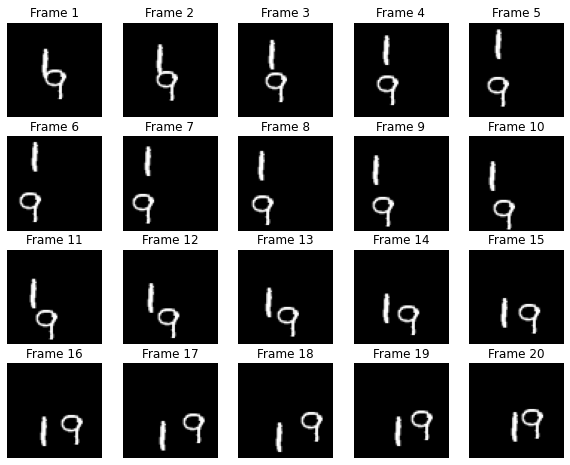

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

# Model 
To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [ ]:
myDO = 0.3

# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    dropout=myDO,
    recurrent_dropout=myDO
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    dropout=myDO,
    recurrent_dropout=myDO
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    dropout=myDO,
    recurrent_dropout=myDO
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

2022-06-12 16:42:13.063629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:42:13.179992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:42:13.180745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:42:13.181825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
# TRAIN

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

2022-06-12 16:42:17.335114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-12 16:42:21.842932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/mul_10' -> 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/add_5', 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/convolution_4' -> 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/add', 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/clip_by_value_2' -> 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/mul_13', 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/Relu' -> 'model/conv_lst_m2d_2/while/body/_502/model/conv_lst_m2d_2/while/mul_11', 'model/conv_lst_m2d_1/while/body/_234/model/conv_lst_m2d_1/while/mul_10' -> 'model/conv_lst_m2d_1/while/body/_234/model/conv_lst_m2d_1/while/add_5', 'model/conv_lst_m2d_1/while/body/_234/mo

180/180 [==============================] - ETA: 0s - loss: 0.0884

2022-06-12 16:44:07.039616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/model/conv_lst_m2d_2/while/body/_97/input/_240' -> 'model/conv_lst_m2d_2/while/body/_97/model/conv_lst_m2d_2/while/mul_10', 'model/conv_lst_m2d_2/while/body/_97/model/conv_lst_m2d_2/while/Relu_1' -> 'model/conv_lst_m2d_2/while/body/_97/model/conv_lst_m2d_2/while/mul_13', 'model/conv_lst_m2d_2/while/body/_97/model/conv_lst_m2d_2/while/convolution_7' -> 'model/conv_lst_m2d_2/while/body/_97/model/conv_lst_m2d_2/while/add_6', 'model/conv_lst_m2d_1/while/body/_49/model/conv_lst_m2d_1/while/clip_by_value_2' -> 'model/conv_lst_m2d_1/while/body/_49/model/conv_lst_m2d_1/while/mul_13', 'model/conv_lst_m2d_1/while/body/_49/model/conv_lst_m2d_1/while/convolution_6' -> 'model/conv_lst_m2d_1/while/body/_49/model/conv_lst_m2d_1/while/add_4', 'model/conv_lst_m2d_1/while/body/_49/model/conv_lst_m2d_

180/180 [==============================] - 115s 568ms/step - loss: 0.0884 - val_loss: 0.2499
Epoch 2/20
180/180 [==============================] - 102s 564ms/step - loss: 0.0333 - val_loss: 0.1597
Epoch 3/20
180/180 [==============================] - 101s 564ms/step - loss: 0.0305 - val_loss: 0.0574
Epoch 4/20
180/180 [==============================] - 100s 554ms/step - loss: 0.0296 - val_loss: 0.0310
Epoch 5/20
180/180 [==============================] - 102s 565ms/step - loss: 0.0290 - val_loss: 0.0283
Epoch 6/20
180/180 [==============================] - 102s 565ms/step - loss: 0.0285 - val_loss: 0.0296
Epoch 7/20
180/180 [==============================] - 99s 553ms/step - loss: 0.0281 - val_loss: 0.0280
Epoch 8/20
180/180 [==============================] - 102s 565ms/step - loss: 0.0278 - val_loss: 0.0315
Epoch 9/20
180/180 [==============================] - 99s 552ms/step - loss: 0.0275 - val_loss: 0.0314
Epoch 10/20
180/180 [==============================] - 99s 552ms/step - loss:

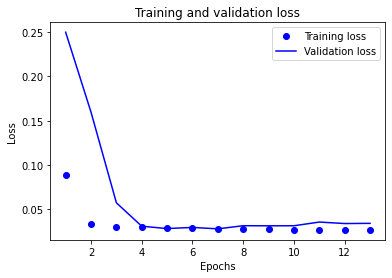

In [ ]:
# Plot learning curves

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss") 
plt.plot(epochs, val_loss_values, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save model
model.save('NextFrameVideo')

# Frame Prediction Visualizations

With our model now constructed and trained, we can generate some example frame predictions based on a new video.

We'll pick a random example from the validation set and then choose the first ten frames from them. From there, we can allow the model to predict 10 new frames, which we can compare to the ground truth frame predictions.

# Load a saved model
model = keras.models.load_model('/kaggle/input/savedmodelzip/NextFrameVideo/')

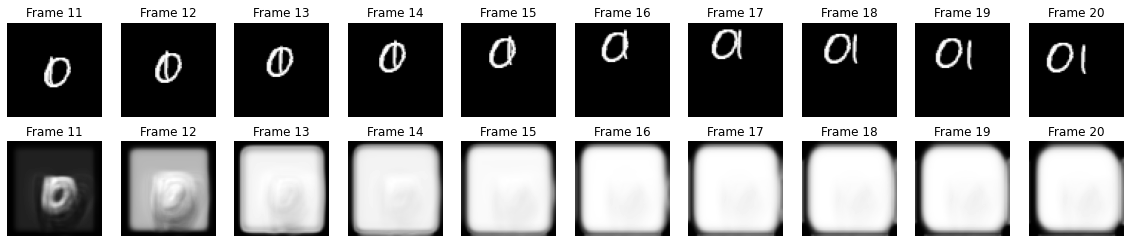

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.....   at INFERENCE it works WITHOUT GPU ...........
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

### The gif / video will display ONLY if you fork this nb and run it

In [ ]:
# Select a few random examples from the dataset.

numVidSamples = 3
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=numVidSamples)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
